<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_2_Sunspots_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicting   stock price with Neural Networks (DNN only)



## Imports

You will use the same imports as before with the addition of the [csv](https://docs.python.org/3/library/csv.html) module. You will need this to parse the CSV file containing the dataset.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import time
start_time = time.time()

## Utilities

You will only have the `plot_series()` dataset here because you no longer need the synthetic data generation functions.

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

You can now download the dataset and inspect the contents. The link in class is from Laurence's repo but we also hosted it in the link below.

In [3]:
import pandas as pd

In [4]:
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\ACB.csv')

In [5]:
data.head

<bound method NDFrame.head of       Unnamed: 0        time   open   high    low  close    volume
0              0  2015-01-05   2.82   2.82   2.78   2.80     55888
1              1  2015-01-06   2.78   2.84   2.76   2.84     89802
2              2  2015-01-07   2.84   2.93   2.84   2.87    232861
3              3  2015-01-08   2.87   2.89   2.85   2.89     14880
4              4  2015-01-09   2.89   2.98   2.85   2.91    693623
...          ...         ...    ...    ...    ...    ...       ...
2354        2354  2024-06-17  24.60  24.60  24.25  24.55   6375848
2355        2355  2024-06-18  24.70  24.70  24.40  24.55   5729760
2356        2356  2024-06-19  24.55  24.70  24.25  24.65   7618993
2357        2357  2024-06-20  24.55  24.85  24.40  24.80  10178313
2358        2358  2024-06-21  24.85  24.85  24.50  24.55   5126289

[2359 rows x 7 columns]>

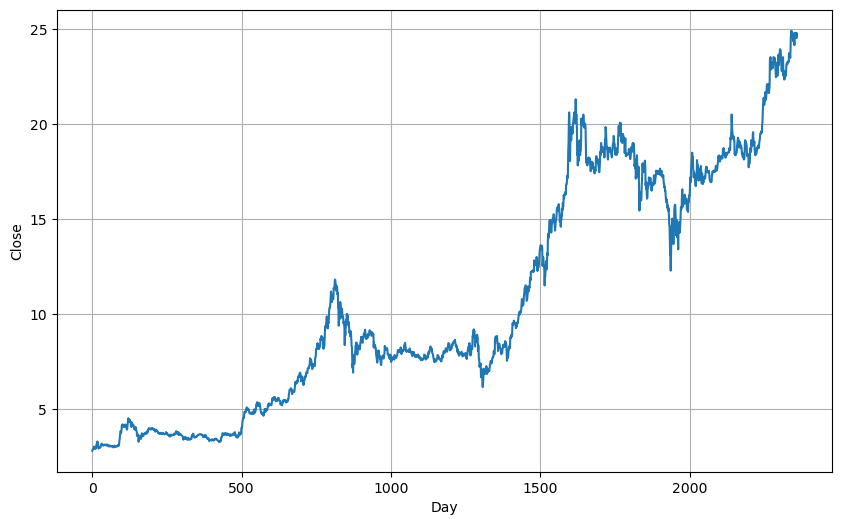

In [25]:
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\ACB.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time, series, xlabel='Day', ylabel='Close')

Running the cell below, you'll see that there are only three columns in the dataset:
1. untitled column containing the day number
2. Date which has the format `YYYY-MM-DD`
3. Mean Total Stock Price

## Split the Dataset

Next, you will split the dataset into training and validation sets. There are 3464 points in the dataset and you will use the first 3000 for training.

In [26]:
# Define the split time
split_time = 2000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

You can then prepare the dataset windows as before. The window size is set to 30 points (equal to 2.5 years) but feel free to change later on if you want to experiment.

In [27]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [28]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

The model will be 3-layer dense network as shown below.

In [29]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 30)                930       
                                                                 
 dense_19 (Dense)            (None, 10)                310       
                                                                 
 dense_20 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


## Tune the Learning Rate

You can pick a learning rate by running the same learning rate scheduler code from previous labs.

In [30]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
62/62 [==============================] - 1s 5ms/step - loss: 7.1935 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 0s 4ms/step - loss: 7.1814 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 0s 4ms/step - loss: 7.1675 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 0s 4ms/step - loss: 7.1520 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 0s 4ms/step - loss: 7.1345 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 0s 4ms/step - loss: 7.1150 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 0s 4ms/step - loss: 7.0931 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 0s 4ms/step - loss: 7.0685 - lr: 2.2387e-08
Epoch 9/100
62/62 [==============================] - 0s 5ms/step - loss: 7.0409 - lr: 2.5119e-08
Epoch 10/100
62/62 [==============================] - 0s 4ms/step - loss: 7.0099 - lr: 2.8184e-08
Epoch 11/100
62/62 [=========

62/62 [==============================] - 0s 3ms/step - loss: 0.0821 - lr: 1.4125e-04
Epoch 85/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0735 - lr: 1.5849e-04
Epoch 86/100
62/62 [==============================] - 0s 4ms/step - loss: 0.0787 - lr: 1.7783e-04
Epoch 87/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0692 - lr: 1.9953e-04
Epoch 88/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0686 - lr: 2.2387e-04
Epoch 89/100
62/62 [==============================] - 0s 4ms/step - loss: 0.0667 - lr: 2.5119e-04
Epoch 90/100
62/62 [==============================] - 0s 4ms/step - loss: 0.0794 - lr: 2.8184e-04
Epoch 91/100
62/62 [==============================] - 0s 4ms/step - loss: 0.0724 - lr: 3.1623e-04
Epoch 92/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0851 - lr: 3.5481e-04
Epoch 93/100
62/62 [==============================] - 0s 4ms/step - loss: 0.0746 - lr: 3.9811e-04
Epoch 94/100
62/62 [=============

(1e-08, 0.001, 0.0, 100.0)

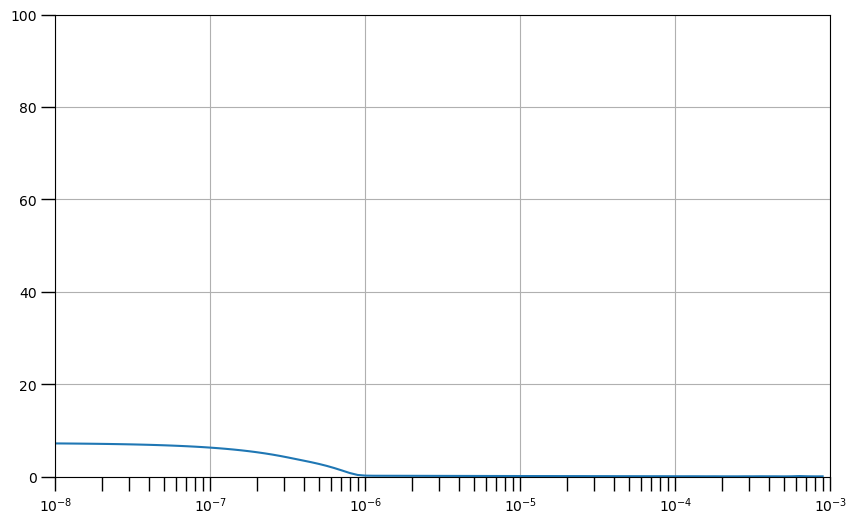

In [31]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

Once you've picked a learning rate, you can rebuild the model and start training.

In [32]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [33]:
# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
62/62 [==============================] - 1s 4ms/step - loss: 6.8969 - mse: 71.2359
Epoch 2/100
62/62 [==============================] - 0s 4ms/step - loss: 5.6356 - mse: 48.9139
Epoch 3/100
62/62 [==============================] - 0s 4ms/step - loss: 4.3568 - mse: 30.7395
Epoch 4/100
62/62 [==============================] - 0s 4ms/step - loss: 3.0585 - mse: 16.6872
Epoch 5/100
62/62 [==============================] - 0s 4ms/step - loss: 1.7419 - mse: 6.8152
Epoch 6/100
62/62 [==============================] - 0s 4ms/step - loss: 0.7071 - mse: 1.9724
Epoch 7/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3105 - mse: 0.7605
Epoch 8/100
62/62 [==============================] - 0s 4ms/step - loss: 0.2503 - mse: 0.6097
Epoch 9/100
62/62 [==============================] - 0s 4ms/step - loss: 0.2444 - mse: 0.5968
Epoch 10/100
62/62 [==============================] - 0s 4ms/step - loss: 0.2428 - mse: 0.5940
Epoch 11/100
62/62 [==============================] - 0

62/62 [==============================] - 0s 3ms/step - loss: 0.1877 - mse: 0.4408
Epoch 88/100
62/62 [==============================] - 0s 3ms/step - loss: 0.1875 - mse: 0.4403
Epoch 89/100
62/62 [==============================] - 0s 3ms/step - loss: 0.1873 - mse: 0.4395
Epoch 90/100
62/62 [==============================] - 0s 3ms/step - loss: 0.1871 - mse: 0.4390
Epoch 91/100
62/62 [==============================] - 0s 3ms/step - loss: 0.1868 - mse: 0.4383
Epoch 92/100
62/62 [==============================] - 0s 3ms/step - loss: 0.1866 - mse: 0.4376
Epoch 93/100
62/62 [==============================] - 0s 3ms/step - loss: 0.1864 - mse: 0.4374
Epoch 94/100
62/62 [==============================] - 0s 3ms/step - loss: 0.1860 - mse: 0.4360
Epoch 95/100
62/62 [==============================] - 0s 3ms/step - loss: 0.1858 - mse: 0.4356
Epoch 96/100
62/62 [==============================] - 0s 4ms/step - loss: 0.1855 - mse: 0.4348
Epoch 97/100
62/62 [==============================] - 0s 3ms/st

## Model Prediction

Now see if the model generates good results. If you used the default parameters of this notebook, you should see the predictions follow the shape of the ground truth with an MSE of around 3. 

In [34]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

12/12 [==============================] - 0s 8ms/step


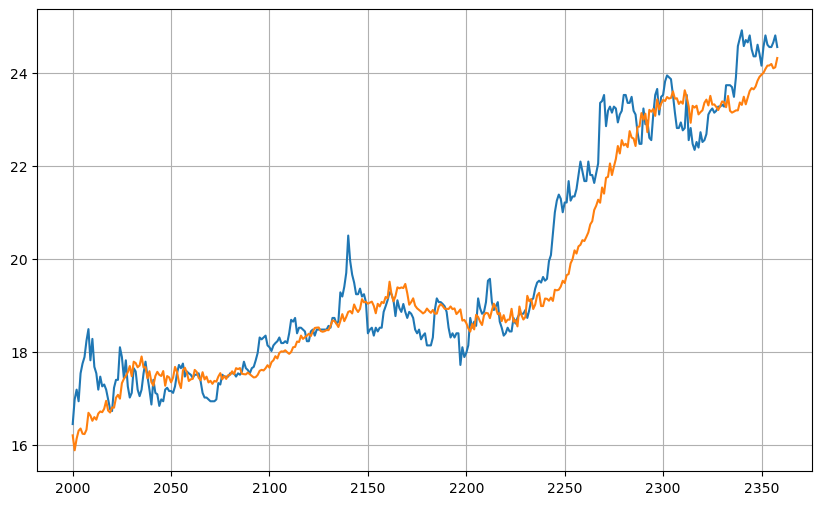

[16.207579  15.8869095 16.137054  16.307018  16.354053  16.241993
 16.23534   16.3276    16.692226  16.631487  16.520405  16.599472
 16.544268  16.67503   16.721008  16.705114  16.778708  16.95003
 16.740316  16.697939  16.807154  16.802027  17.016006  17.078257
 16.995886  17.328327  17.420515  17.483074  17.56457   17.6961
 17.47727   17.789595  17.761307  17.670706  17.709053  17.902325
 17.666536  17.673155  17.435144  17.585247  17.348883  17.275185
 17.483728  17.572138  17.507477  17.482775  17.588919  17.273344
 17.481337  17.453526  17.346096  17.447535  17.678179  17.571938
 17.346792  17.223137  17.599005  17.659529  17.555176  17.375914
 17.411282  17.42151   17.613571  17.571108  17.442282  17.391819
 17.564577  17.409132  17.468851  17.344687  17.379688  17.314768
 17.377378  17.361147  17.470175  17.544004  17.412294  17.482351
 17.420145  17.501009  17.506777  17.583097  17.521269  17.650991
 17.630787  17.653217  17.531424  17.521435  17.517235  17.55557
 17.519308  17

In [35]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

In [36]:
# Compute the MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
m = tf.keras.metrics.Accuracy()
m.result()

0.47700304


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [37]:
import tensorflow as tf
import numpy as np

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

MSE: 0.47700304
Mean Error Percent: 0.02538180000802843
Accuracy: 0.9746181999919715


## Wrap Up

In this lab, you built a relatively simple DNN to forecast VCB stock price for a given day. We encourage you to tweak the parameters or train longer and see the best results you can get. 

Epoch 1/100
62/62 [==============================] - 1s 5ms/step - loss: 9.3084 - mse: 125.2662
Epoch 2/100
62/62 [==============================] - 0s 5ms/step - loss: 8.6053 - mse: 107.8930
Epoch 3/100
62/62 [==============================] - 0s 6ms/step - loss: 7.9467 - mse: 92.7886
Epoch 4/100
62/62 [==============================] - 0s 6ms/step - loss: 7.2945 - mse: 78.9423
Epoch 5/100
62/62 [==============================] - 0s 5ms/step - loss: 6.6080 - mse: 65.4609
Epoch 6/100
62/62 [==============================] - 0s 5ms/step - loss: 5.7776 - mse: 50.8084
Epoch 7/100
62/62 [==============================] - 0s 5ms/step - loss: 4.8458 - mse: 36.7219
Epoch 8/100
62/62 [==============================] - 0s 5ms/step - loss: 3.8921 - mse: 24.7331
Epoch 9/100
62/62 [==============================] - 0s 5ms/step - loss: 2.9158 - mse: 14.9168
Epoch 10/100
62/62 [==============================] - 0s 5ms/step - loss: 1.9302 - mse: 7.5210
Epoch 11/100
62/62 [============================

62/62 [==============================] - 0s 4ms/step - loss: 0.0872 - mse: 0.1892
Epoch 88/100
62/62 [==============================] - 0s 5ms/step - loss: 0.0873 - mse: 0.1894
Epoch 89/100
62/62 [==============================] - 0s 5ms/step - loss: 0.0871 - mse: 0.1888
Epoch 90/100
62/62 [==============================] - 0s 4ms/step - loss: 0.0870 - mse: 0.1886
Epoch 91/100
62/62 [==============================] - 0s 5ms/step - loss: 0.0871 - mse: 0.1888
Epoch 92/100
62/62 [==============================] - 0s 4ms/step - loss: 0.0869 - mse: 0.1885
Epoch 93/100
62/62 [==============================] - 0s 5ms/step - loss: 0.0869 - mse: 0.1885
Epoch 94/100
62/62 [==============================] - 0s 5ms/step - loss: 0.0868 - mse: 0.1882
Epoch 95/100
62/62 [==============================] - 0s 4ms/step - loss: 0.0868 - mse: 0.1882
Epoch 96/100
62/62 [==============================] - 0s 4ms/step - loss: 0.0867 - mse: 0.1880
Epoch 97/100
62/62 [==============================] - 0s 5ms/st

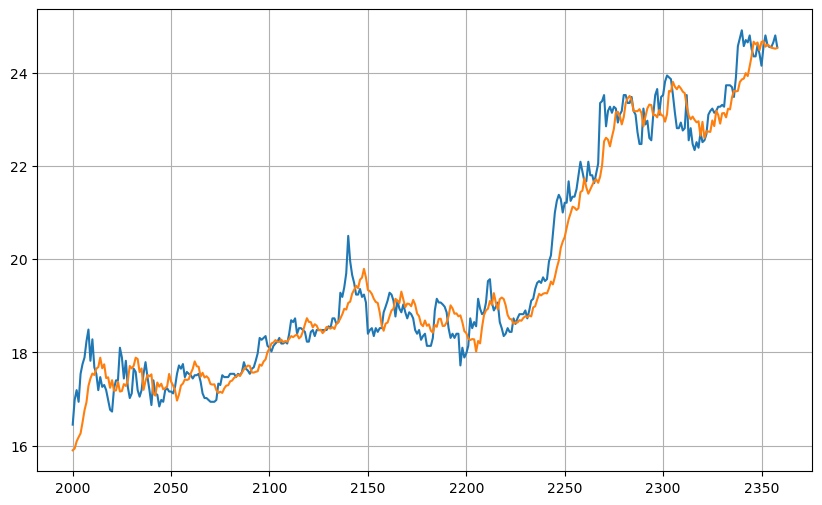

[15.899946 15.937161 16.090294 16.181042 16.262524 16.499643 16.75674
 16.932686 17.279613 17.43903  17.546747 17.515205 17.649767 17.684269
 17.887066 17.659372 17.744194 17.449013 17.465935 17.240717 17.403772
 17.17938  17.183023 17.369835 17.159628 17.171247 17.31965  17.27997
 17.396708 17.708376 17.65538  17.714045 17.886349 17.85858  17.576677
 17.65455  17.197464 17.386776 17.51415  17.48753  17.528765 17.113749
 17.073559 17.353468 17.26605  17.327492 17.207958 17.231594 17.272406
 17.537678 17.372879 17.291943 17.18982  16.966387 17.09375  17.289385
 17.330946 17.421808 17.406977 17.424814 17.55186  17.64677  17.806492
 17.705492 17.690622 17.48068  17.56154  17.460548 17.488161 17.443815
 17.321661 17.309551 17.314503 17.189426 17.13015  17.155918 17.130587
 17.226473 17.28661  17.29479  17.378202 17.39508  17.453428 17.477278
 17.517956 17.492836 17.566088 17.635767 17.67689  17.717186 17.707739
 17.56935  17.566566 17.582968 17.594738 17.73939  17.713139 17.803967
 17.8501

In [46]:
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\ACB.csv')
# Define the split time
split_time = 2000
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\ACB.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 500

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

**DHG**

Epoch 1/100
62/62 [==============================] - 1s 5ms/step - loss: 5.3708 - mse: 71.5950
Epoch 2/100
62/62 [==============================] - 0s 5ms/step - loss: 1.8817 - mse: 11.2806
Epoch 3/100
62/62 [==============================] - 0s 5ms/step - loss: 1.8556 - mse: 11.0221
Epoch 4/100
62/62 [==============================] - 0s 5ms/step - loss: 1.8300 - mse: 10.8874
Epoch 5/100
62/62 [==============================] - 0s 6ms/step - loss: 1.8507 - mse: 10.8394
Epoch 6/100
62/62 [==============================] - 0s 5ms/step - loss: 1.8024 - mse: 10.4714
Epoch 7/100
62/62 [==============================] - 0s 5ms/step - loss: 1.7948 - mse: 10.3813
Epoch 8/100
62/62 [==============================] - 0s 5ms/step - loss: 1.7784 - mse: 10.2840
Epoch 9/100
62/62 [==============================] - 0s 5ms/step - loss: 1.7846 - mse: 10.3724
Epoch 10/100
62/62 [==============================] - 0s 5ms/step - loss: 1.7809 - mse: 10.2715
Epoch 11/100
62/62 [=============================

62/62 [==============================] - 0s 4ms/step - loss: 1.2633 - mse: 5.9478
Epoch 88/100
62/62 [==============================] - 0s 4ms/step - loss: 1.2814 - mse: 6.0125
Epoch 89/100
62/62 [==============================] - 0s 4ms/step - loss: 1.2601 - mse: 5.9604
Epoch 90/100
62/62 [==============================] - 0s 5ms/step - loss: 1.2520 - mse: 5.8706
Epoch 91/100
62/62 [==============================] - 0s 4ms/step - loss: 1.2372 - mse: 5.7736
Epoch 92/100
62/62 [==============================] - 0s 4ms/step - loss: 1.2313 - mse: 5.7437
Epoch 93/100
62/62 [==============================] - 0s 4ms/step - loss: 1.2372 - mse: 5.7880
Epoch 94/100
62/62 [==============================] - 0s 4ms/step - loss: 1.2757 - mse: 5.9717
Epoch 95/100
62/62 [==============================] - 0s 5ms/step - loss: 1.2563 - mse: 5.8591
Epoch 96/100
62/62 [==============================] - 0s 4ms/step - loss: 1.2526 - mse: 5.7922
Epoch 97/100
62/62 [==============================] - 0s 4ms/st

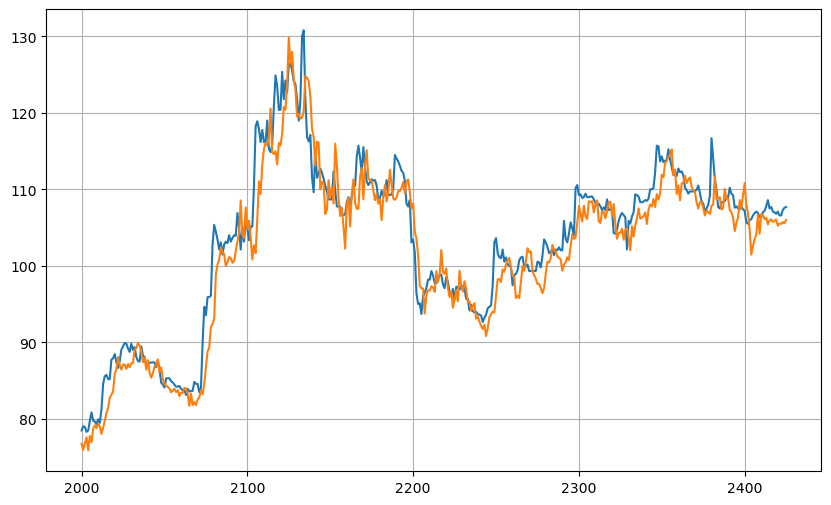

[ 76.718765  75.92207   76.830185  77.57326   75.87994   77.75722
  76.91647   78.720146  79.135185  78.76996   79.377235  79.00326
  78.01407   78.80953   79.718506  80.77442   81.40755   82.72579
  83.127106  83.59828   85.86218   86.471596  88.06162   87.00883
  86.427124  87.06862   87.10491   86.525185  87.151085  86.736374
  87.25491   87.285995  89.02646   89.22363   89.926186  89.58998
  88.76674   87.39065   87.994194  86.44197   87.65993   86.09174
  85.37625   85.93927   86.84624   86.99712   87.77341   86.08659
  86.735664  85.24328   84.50236   84.355675  84.17426   83.945724
  83.46381   83.71058   83.92344   83.49524   83.75346   82.961296
  83.41924   83.37716   84.03209   83.93685   83.32636   81.68211
  83.2947    81.79195   82.1916    81.78331   82.49426   82.83586
  83.69622   83.198685  84.544334  86.73479   88.815125  89.28681
  92.007965  92.37107   93.11881   98.868835 100.17892  100.77779
 102.40989  101.80565  101.545975  99.97428  100.45971  101.15676
 101.00

In [48]:
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\DHG.csv')
# Define the split time
split_time = 2000
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\DHG.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 500

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

In [ ]:
**FPT**

Epoch 1/100
62/62 [==============================] - 1s 4ms/step - loss: 7.2512 - mse: 93.4792
Epoch 2/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6514 - mse: 2.7000
Epoch 3/100
62/62 [==============================] - 0s 4ms/step - loss: 0.5525 - mse: 2.3248
Epoch 4/100
62/62 [==============================] - 0s 5ms/step - loss: 0.5441 - mse: 2.2630
Epoch 5/100
62/62 [==============================] - 0s 4ms/step - loss: 0.5312 - mse: 2.1927
Epoch 6/100
62/62 [==============================] - 0s 4ms/step - loss: 0.5152 - mse: 2.1082
Epoch 7/100
62/62 [==============================] - 0s 4ms/step - loss: 0.4979 - mse: 2.0167
Epoch 8/100
62/62 [==============================] - 0s 4ms/step - loss: 0.4738 - mse: 1.8965
Epoch 9/100
62/62 [==============================] - 0s 4ms/step - loss: 0.4511 - mse: 1.7778
Epoch 10/100
62/62 [==============================] - 0s 4ms/step - loss: 0.4437 - mse: 1.7236
Epoch 11/100
62/62 [==============================] - 0s 4

62/62 [==============================] - 0s 4ms/step - loss: 0.3564 - mse: 1.2323
Epoch 88/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3552 - mse: 1.2288
Epoch 89/100
62/62 [==============================] - 0s 3ms/step - loss: 0.3547 - mse: 1.2275
Epoch 90/100
62/62 [==============================] - 0s 3ms/step - loss: 0.3545 - mse: 1.2264
Epoch 91/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3558 - mse: 1.2264
Epoch 92/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3542 - mse: 1.2256
Epoch 93/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3517 - mse: 1.2180
Epoch 94/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3542 - mse: 1.2242
Epoch 95/100
62/62 [==============================] - 0s 3ms/step - loss: 0.3524 - mse: 1.2194
Epoch 96/100
62/62 [==============================] - 0s 3ms/step - loss: 0.3520 - mse: 1.2129
Epoch 97/100
62/62 [==============================] - 0s 4ms/st

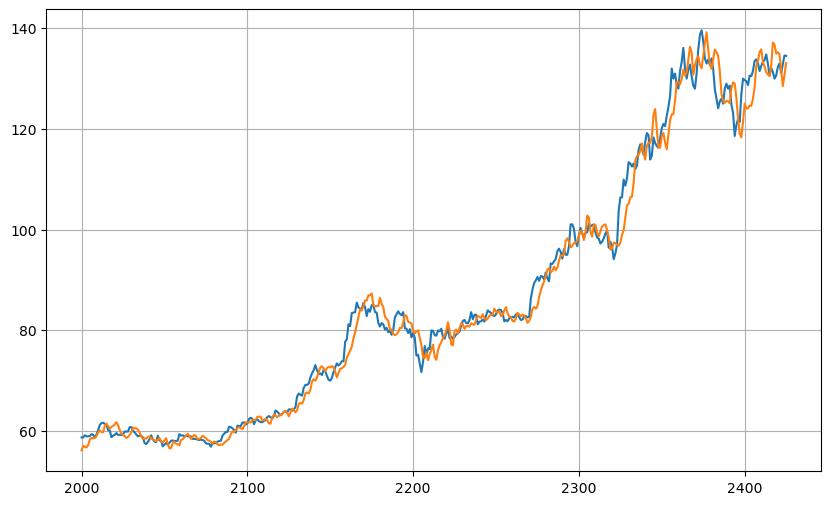

[ 56.153015  57.037086  56.824837  56.73879   57.178802  58.328857
  58.604073  58.505882  58.61685   58.945534  59.693123  60.124714
  59.749817  59.707947  60.978634  61.45254   60.965836  60.457737
  60.822174  60.978207  61.321182  61.73591   61.1766    60.14868
  59.480515  59.235348  58.926506  58.597183  58.808666  59.228973
  59.706844  60.668934  60.506134  60.53922   60.260765  59.665596
  58.877666  58.36621   58.536446  58.439278  58.814377  58.92852
  58.5701    58.314285  58.101105  57.922195  58.241608  58.589542
  57.971664  57.694138  58.122936  58.529438  57.443096  56.52427
  56.590004  57.561226  57.889896  57.45604   57.35395   57.12591
  58.19937   58.347847  58.680576  59.07589   59.459023  59.012444
  58.40656   58.82148   59.184143  58.960255  58.37706   58.43214
  58.582882  59.04429   58.787987  58.573112  58.158405  58.076363
  57.822384  57.530533  57.90122   57.72944   57.360558  57.153725
  57.322258  57.25476   57.61562   57.907646  58.169296  58.418465


In [49]:
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\FPT.csv')
# Define the split time
split_time = 2000
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\FPT.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

In [ ]:
**HAP**

Epoch 1/100
62/62 [==============================] - 1s 4ms/step - loss: 4.4153 - mse: 36.7791
Epoch 2/100
62/62 [==============================] - 0s 3ms/step - loss: 4.2287 - mse: 34.0772
Epoch 3/100
62/62 [==============================] - 0s 3ms/step - loss: 4.0462 - mse: 31.5120
Epoch 4/100
62/62 [==============================] - 1s 7ms/step - loss: 3.8653 - mse: 29.0733
Epoch 5/100
62/62 [==============================] - 0s 4ms/step - loss: 3.6852 - mse: 26.7452
Epoch 6/100
62/62 [==============================] - 0s 4ms/step - loss: 3.5040 - mse: 24.5113
Epoch 7/100
62/62 [==============================] - 0s 5ms/step - loss: 3.3220 - mse: 22.3605
Epoch 8/100
62/62 [==============================] - 0s 4ms/step - loss: 3.1390 - mse: 20.3030
Epoch 9/100
62/62 [==============================] - 0s 4ms/step - loss: 2.9541 - mse: 18.3379
Epoch 10/100
62/62 [==============================] - 0s 4ms/step - loss: 2.7666 - mse: 16.4469
Epoch 11/100
62/62 [=============================

62/62 [==============================] - 0s 3ms/step - loss: 0.1342 - mse: 0.4253
Epoch 88/100
62/62 [==============================] - 0s 3ms/step - loss: 0.1339 - mse: 0.4242
Epoch 89/100
62/62 [==============================] - 0s 4ms/step - loss: 0.1337 - mse: 0.4231
Epoch 90/100
62/62 [==============================] - 0s 4ms/step - loss: 0.1335 - mse: 0.4219
Epoch 91/100
62/62 [==============================] - 0s 3ms/step - loss: 0.1332 - mse: 0.4209
Epoch 92/100
62/62 [==============================] - 0s 4ms/step - loss: 0.1330 - mse: 0.4198
Epoch 93/100
62/62 [==============================] - 0s 4ms/step - loss: 0.1328 - mse: 0.4188
Epoch 94/100
62/62 [==============================] - 0s 4ms/step - loss: 0.1326 - mse: 0.4178
Epoch 95/100
62/62 [==============================] - 0s 3ms/step - loss: 0.1323 - mse: 0.4169
Epoch 96/100
62/62 [==============================] - 0s 4ms/step - loss: 0.1321 - mse: 0.4159
Epoch 97/100
62/62 [==============================] - 0s 3ms/st

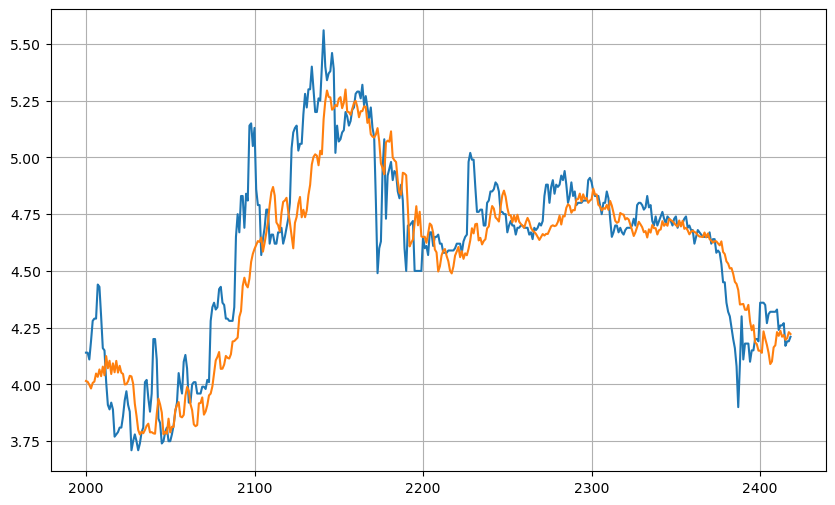

[4.015142  4.011877  3.9985404 3.9821804 4.0067377 4.012738  4.0481296
 4.033483  4.066027  4.036269  4.0786295 4.0403957 4.1247063 4.0711565
 4.1042547 4.0459986 4.093085  4.0536656 4.1037645 4.0520926 4.082085
 4.0515695 4.0461574 3.999974  4.000975  4.0141683 4.038104  4.0352407
 4.0034223 3.9147427 3.8618126 3.7995517 3.77955   3.791951  3.7849143
 3.7993484 3.8176486 3.8271964 3.7888393 3.789994  3.7847593 3.7829037
 3.869984  3.9373531 3.9117    3.8760278 3.7803814 3.7911491 3.7826552
 3.8492005 3.7886121 3.813606  3.8125348 3.8870316 3.9088452 3.922351
 3.8591983 3.8550327 3.865778  3.9492974 3.9886363 3.9726682 3.9138381
 3.8864253 3.8242383 3.8160036 3.8209305 3.9167833 3.9180121 3.9428933
 3.8669574 3.8809474 3.908978  3.951814  3.959586  3.99107   4.047672
 4.105997  4.121174  4.142879  4.0685406 4.069436  4.087423  4.125537
 4.117252  4.114227  4.132926  4.18916   4.190874  4.198755  4.2061987
 4.2974463 4.322824  4.4333696 4.4701996 4.4392705 4.4275537 4.465726
 4.5398374 

In [50]:
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\HAP.csv')
# Define the split time
split_time = 2000
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\HAP.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

**HNX**

Epoch 1/100
46/46 [==============================] - 1s 5ms/step - loss: 239.0883 - mse: 81834.0469
Epoch 2/100
46/46 [==============================] - 0s 5ms/step - loss: 22.1805 - mse: 910.0975
Epoch 3/100
46/46 [==============================] - 0s 5ms/step - loss: 13.2316 - mse: 514.2405
Epoch 4/100
46/46 [==============================] - 0s 5ms/step - loss: 12.8251 - mse: 464.8213
Epoch 5/100
46/46 [==============================] - 0s 5ms/step - loss: 11.6336 - mse: 390.0060
Epoch 6/100
46/46 [==============================] - 0s 5ms/step - loss: 11.1700 - mse: 353.8998
Epoch 7/100
46/46 [==============================] - 0s 5ms/step - loss: 11.3376 - mse: 368.4058
Epoch 8/100
46/46 [==============================] - 0s 5ms/step - loss: 10.9891 - mse: 348.4442
Epoch 9/100
46/46 [==============================] - 0s 5ms/step - loss: 10.7965 - mse: 331.9117
Epoch 10/100
46/46 [==============================] - 0s 5ms/step - loss: 10.6693 - mse: 324.4753
Epoch 11/100
46/46 [======

46/46 [==============================] - 0s 4ms/step - loss: 7.1840 - mse: 156.6070
Epoch 86/100
46/46 [==============================] - 0s 4ms/step - loss: 7.0771 - mse: 152.7576
Epoch 87/100
46/46 [==============================] - 0s 4ms/step - loss: 7.2762 - mse: 157.0388
Epoch 88/100
46/46 [==============================] - 0s 5ms/step - loss: 6.9235 - mse: 145.5667
Epoch 89/100
46/46 [==============================] - 0s 4ms/step - loss: 6.8225 - mse: 143.0410
Epoch 90/100
46/46 [==============================] - 0s 5ms/step - loss: 6.7701 - mse: 141.5618
Epoch 91/100
46/46 [==============================] - 0s 5ms/step - loss: 6.7224 - mse: 138.2643
Epoch 92/100
46/46 [==============================] - 0s 4ms/step - loss: 6.9079 - mse: 145.2232
Epoch 93/100
46/46 [==============================] - 0s 5ms/step - loss: 7.0791 - mse: 144.7607
Epoch 94/100
46/46 [==============================] - 0s 5ms/step - loss: 6.6644 - mse: 136.6912
Epoch 95/100
46/46 [=======================

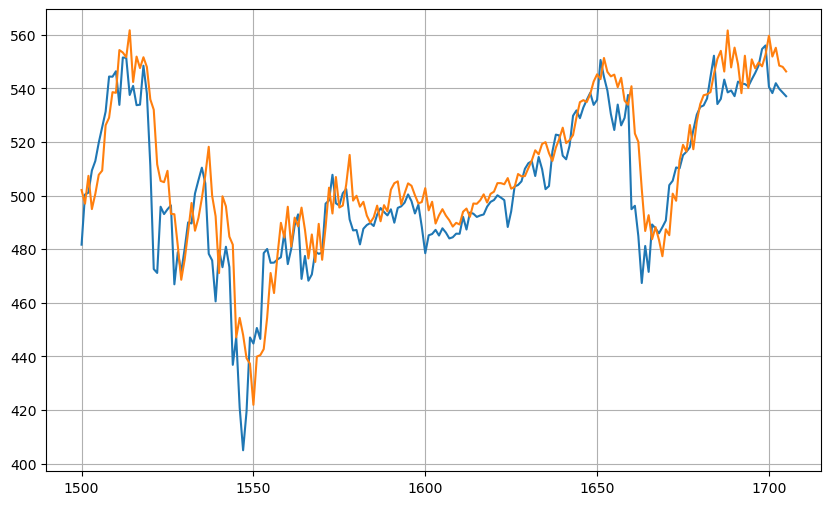

[502.07144 496.97986 507.36102 494.96844 500.65152 507.7457  509.32132
 526.2423  529.0293  538.5626  538.3169  554.2617  553.352   551.61847
 561.64105 542.3557  551.82587 547.5483  551.58405 547.9648  535.8836
 532.01294 511.64404 505.46902 504.99307 509.2357  493.1992  493.04312
 481.2244  468.61368 476.15118 486.38568 497.23355 486.88577 491.62415
 498.99484 507.59756 518.1931  499.84598 492.29562 471.09686 499.73346
 496.00635 484.68622 481.69452 447.11316 454.39276 448.05032 439.35535
 437.28485 421.96692 439.9553  440.4923  442.752   454.5634  471.12265
 463.65686 477.74014 489.83206 484.3341  495.8341  481.00052 491.78473
 488.52567 495.50378 487.2188  476.55862 485.49277 475.2523  489.45782
 476.06052 488.21176 502.9368  493.31815 506.92166 495.5497  496.26904
 504.13904 515.158   498.12494 499.92804 495.8693  497.67252 492.5469
 489.90677 491.89594 496.2501  490.41718 496.42395 494.12332 502.1943
 504.615   505.30273 496.7522  500.85458 504.5616  503.65024 500.13058
 497.0787

In [55]:
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\HNX.csv')
# Define the split time
split_time = 1500
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\HNX.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size =500

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

In [ ]:
**HNX30**

Epoch 1/100
46/46 [==============================] - 1s 6ms/step - loss: 271.1269 - mse: 88950.5703
Epoch 2/100
46/46 [==============================] - 0s 5ms/step - loss: 34.9207 - mse: 2093.5088
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: 19.3076 - mse: 962.5167
Epoch 4/100
46/46 [==============================] - 0s 5ms/step - loss: 16.9169 - mse: 718.2728
Epoch 5/100
46/46 [==============================] - 0s 6ms/step - loss: 16.3990 - mse: 661.6723
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: 14.9719 - mse: 513.3257
Epoch 7/100
46/46 [==============================] - 0s 6ms/step - loss: 14.6257 - mse: 510.6062
Epoch 8/100
46/46 [==============================] - 0s 6ms/step - loss: 13.3711 - mse: 424.2185
Epoch 9/100
46/46 [==============================] - 0s 6ms/step - loss: 12.5163 - mse: 370.1676
Epoch 10/100
46/46 [==============================] - 0s 6ms/step - loss: 14.2153 - mse: 455.4552
Epoch 11/100
46/46 [=====

46/46 [==============================] - 0s 6ms/step - loss: 7.3290 - mse: 157.4818
Epoch 86/100
46/46 [==============================] - 0s 6ms/step - loss: 7.3298 - mse: 150.2825
Epoch 87/100
46/46 [==============================] - 0s 6ms/step - loss: 7.2179 - mse: 154.2383
Epoch 88/100
46/46 [==============================] - 0s 5ms/step - loss: 7.4246 - mse: 158.1363
Epoch 89/100
46/46 [==============================] - 0s 5ms/step - loss: 7.1944 - mse: 151.5776
Epoch 90/100
46/46 [==============================] - 0s 5ms/step - loss: 6.9858 - mse: 145.0583
Epoch 91/100
46/46 [==============================] - 0s 5ms/step - loss: 6.9054 - mse: 140.2397
Epoch 92/100
46/46 [==============================] - 0s 5ms/step - loss: 6.9711 - mse: 147.5612
Epoch 93/100
46/46 [==============================] - 0s 6ms/step - loss: 7.0411 - mse: 149.2939
Epoch 94/100
46/46 [==============================] - 0s 6ms/step - loss: 6.9773 - mse: 147.3390
Epoch 95/100
46/46 [=======================

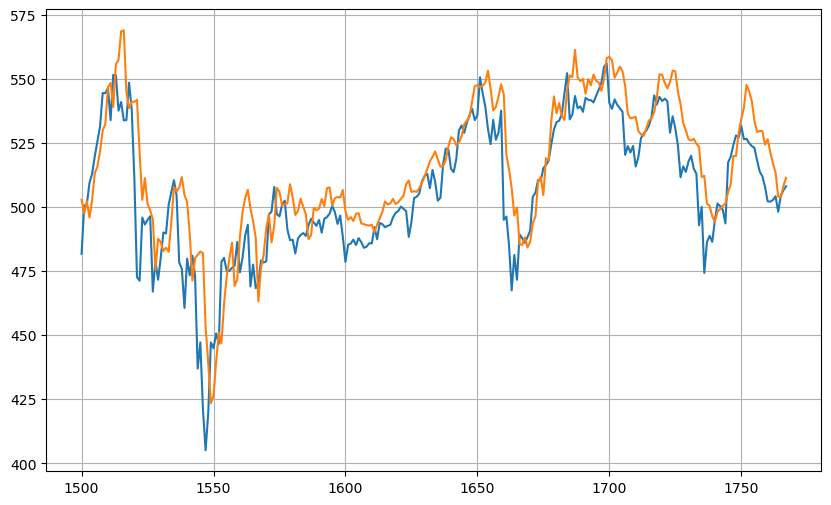

[502.7773  497.39154 502.19452 495.83508 502.739   513.14215 515.6495
 521.70355 529.7534  532.31036 546.7002  548.31    538.94867 555.68396
 557.32916 568.52673 568.885   544.63464 538.4561  541.0338  540.94476
 541.74744 520.96716 502.71832 511.20856 501.15714 498.5893  495.29425
 475.3315  487.57034 486.16495 482.73203 484.03778 482.4263  493.8508
 507.68365 506.0377  507.5003  511.61606 504.57086 501.9937  489.2006
 471.276   479.95004 481.2793  482.55087 481.9538  453.14124 439.04745
 423.41266 426.1223  439.61716 450.89252 446.75232 462.2336  472.80927
 479.68533 486.0028  469.1442  471.71896 488.23163 497.9502  503.4205
 506.61923 499.43436 494.35883 487.89178 463.0778  476.15533 481.2173
 492.02808 496.89856 486.12512 492.51364 507.41425 505.81656 500.405
 501.076   501.41397 508.8176  503.70486 496.83893 498.38373 503.17255
 500.04285 497.03726 487.36066 489.03696 499.6409  498.60892 499.3585
 503.06488 500.25864 507.29495 507.5716  500.44174 503.3726  503.8328
 503.6564  506.

In [56]:
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\HNX30.csv')
# Define the split time
split_time =1500
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\HNX30.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 100

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

**HPG**

Epoch 1/100
62/62 [==============================] - 1s 4ms/step - loss: 3.7684 - mse: 28.2470
Epoch 2/100
62/62 [==============================] - 0s 4ms/step - loss: 1.0157 - mse: 3.8417
Epoch 3/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6169 - mse: 2.2275
Epoch 4/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6059 - mse: 2.1824
Epoch 5/100
62/62 [==============================] - 0s 5ms/step - loss: 0.5955 - mse: 2.1286
Epoch 6/100
62/62 [==============================] - 0s 4ms/step - loss: 0.5851 - mse: 2.0774
Epoch 7/100
62/62 [==============================] - 0s 4ms/step - loss: 0.5726 - mse: 2.0166
Epoch 8/100
62/62 [==============================] - 0s 4ms/step - loss: 0.5617 - mse: 1.9592
Epoch 9/100
62/62 [==============================] - 0s 4ms/step - loss: 0.5549 - mse: 1.9413
Epoch 10/100
62/62 [==============================] - 0s 4ms/step - loss: 0.5486 - mse: 1.8919
Epoch 11/100
62/62 [==============================] - 0s 4

62/62 [==============================] - 0s 4ms/step - loss: 0.3250 - mse: 0.9242
Epoch 88/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3237 - mse: 0.9180
Epoch 89/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3210 - mse: 0.9078
Epoch 90/100
62/62 [==============================] - 0s 3ms/step - loss: 0.3185 - mse: 0.9019
Epoch 91/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3171 - mse: 0.8970
Epoch 92/100
62/62 [==============================] - 0s 3ms/step - loss: 0.3156 - mse: 0.8868
Epoch 93/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3121 - mse: 0.8774
Epoch 94/100
62/62 [==============================] - 0s 3ms/step - loss: 0.3099 - mse: 0.8719
Epoch 95/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3102 - mse: 0.8691
Epoch 96/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3069 - mse: 0.8567
Epoch 97/100
62/62 [==============================] - 0s 4ms/st

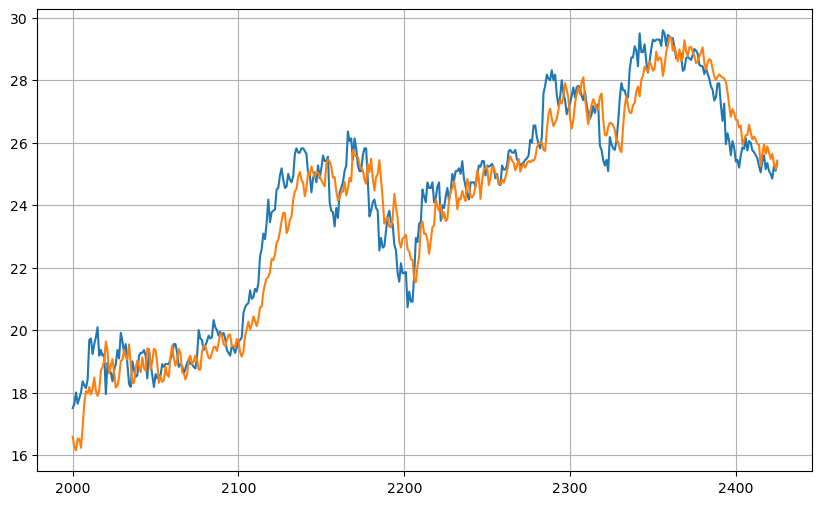

[16.583353 16.251026 16.149982 16.525673 16.50074  16.230433 16.904226
 17.658278 18.045458 17.972078 18.17395  17.935646 18.113148 18.478596
 18.04703  17.889353 18.059778 18.698395 18.820753 19.000292 19.630442
 19.304539 18.61007  18.860344 19.068916 18.638166 18.160357 18.217237
 18.504074 19.014902 19.043453 19.366266 19.149006 19.054125 19.540403
 18.906687 18.293121 18.315622 18.787874 19.023499 18.827408 18.649942
 19.123407 18.780388 18.705706 19.412687 19.395525 18.730957 18.987299
 19.39956  19.353367 18.91445  18.310667 18.52759  18.337809 18.39453
 18.833378 18.56191  18.50545  19.165203 19.508335 19.084082 18.85568
 19.056433 19.392767 19.255926 18.662964 18.611372 18.418102 18.578264
 19.079895 19.18111  18.905788 19.00494  19.180443 19.06079  18.733727
 18.733807 19.306738 19.485891 19.489847 19.282606 19.10412  19.093016
 19.275892 19.452505 19.469664 19.33064  19.594183 19.888998 19.825794
 19.548145 19.491064 19.669544 19.8468   19.851538 19.47357  19.505209
 19.4439

In [57]:
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\HPG.csv')
# Define the split time
split_time = 2000
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\HPG.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

Epoch 1/100
62/62 [==============================] - 1s 4ms/step - loss: 2.8486 - mse: 19.5830
Epoch 2/100
62/62 [==============================] - 0s 4ms/step - loss: 0.7167 - mse: 2.6882
Epoch 3/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6972 - mse: 2.6478
Epoch 4/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6994 - mse: 2.6173
Epoch 5/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6871 - mse: 2.6010
Epoch 6/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6814 - mse: 2.5625
Epoch 7/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6797 - mse: 2.5451
Epoch 8/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6872 - mse: 2.5648
Epoch 9/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6762 - mse: 2.5245
Epoch 10/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6739 - mse: 2.5075
Epoch 11/100
62/62 [==============================] - 0s 4

62/62 [==============================] - 0s 5ms/step - loss: 0.5098 - mse: 1.7324
Epoch 88/100
62/62 [==============================] - 0s 4ms/step - loss: 0.5085 - mse: 1.7204
Epoch 89/100
62/62 [==============================] - 0s 3ms/step - loss: 0.5102 - mse: 1.7362
Epoch 90/100
62/62 [==============================] - 0s 4ms/step - loss: 0.5086 - mse: 1.7187
Epoch 91/100
62/62 [==============================] - 0s 4ms/step - loss: 0.5047 - mse: 1.7083
Epoch 92/100
62/62 [==============================] - 0s 4ms/step - loss: 0.5028 - mse: 1.7066
Epoch 93/100
62/62 [==============================] - 0s 4ms/step - loss: 0.5062 - mse: 1.7213
Epoch 94/100
62/62 [==============================] - 0s 4ms/step - loss: 0.5025 - mse: 1.7006
Epoch 95/100
62/62 [==============================] - 0s 4ms/step - loss: 0.5027 - mse: 1.6869
Epoch 96/100
62/62 [==============================] - 0s 4ms/step - loss: 0.4993 - mse: 1.6834
Epoch 97/100
62/62 [==============================] - 0s 4ms/st

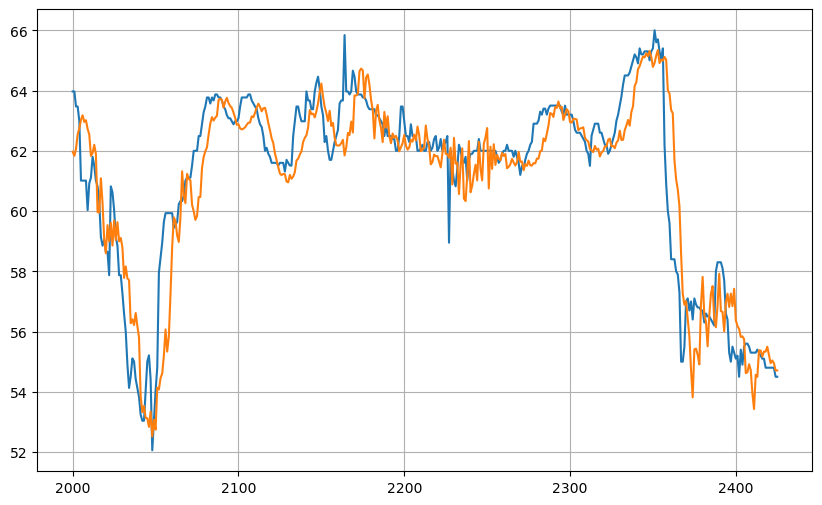

[61.969704 61.832893 62.069202 62.54538  62.741272 63.031517 63.17881
 62.95684  63.014977 62.723824 62.53904  61.828293 61.92901  62.1991
 61.89376  59.96308  59.94796  61.086826 60.266502 59.059998 58.597557
 59.532825 58.993965 59.608887 58.85444  59.68802  59.036777 59.63097
 58.99309  59.10712  58.787315 57.781643 58.162292 57.764984 57.70717
 56.276012 56.407715 56.216103 56.615955 56.184433 55.809586 53.84424
 53.324898 53.533882 53.135788 53.123333 52.836304 53.34559  52.51607
 53.074112 52.744804 54.139763 54.078506 54.458282 54.610847 55.197033
 56.070625 55.33589  55.84603  57.24919  58.807186 59.790253 59.658203
 59.193535 58.975067 59.79846  61.318764 60.523415 60.261646 61.23423
 61.064457 61.02193  60.206734 59.99475  59.70629  59.83746  60.464985
 60.467327 61.423367 61.792767 61.982857 62.116318 62.540447 62.90789
 63.11668  63.003883 63.099716 63.159935 63.68482  63.72583  63.69253
 63.431236 63.636993 63.757202 63.5819   63.48726  63.421528 63.269432
 63.09149  62.86

In [62]:
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\KDC.csv')
# Define the split time
split_time = 2000
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\KDC.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

Epoch 1/100
62/62 [==============================] - 1s 4ms/step - loss: 22.3760 - mse: 670.2461
Epoch 2/100
62/62 [==============================] - 0s 4ms/step - loss: 4.3735 - mse: 39.4187
Epoch 3/100
62/62 [==============================] - 0s 4ms/step - loss: 1.5517 - mse: 11.7288
Epoch 4/100
62/62 [==============================] - 0s 4ms/step - loss: 1.4748 - mse: 10.9429
Epoch 5/100
62/62 [==============================] - 0s 4ms/step - loss: 1.4290 - mse: 10.4288
Epoch 6/100
62/62 [==============================] - 0s 4ms/step - loss: 1.3955 - mse: 10.0274
Epoch 7/100
62/62 [==============================] - 0s 4ms/step - loss: 1.3717 - mse: 9.7568
Epoch 8/100
62/62 [==============================] - 0s 4ms/step - loss: 1.3543 - mse: 9.4906
Epoch 9/100
62/62 [==============================] - 0s 4ms/step - loss: 1.3394 - mse: 9.3287
Epoch 10/100
62/62 [==============================] - 0s 4ms/step - loss: 1.3236 - mse: 9.1380
Epoch 11/100
62/62 [==============================]

62/62 [==============================] - 0s 3ms/step - loss: 0.6774 - mse: 3.3310
Epoch 88/100
62/62 [==============================] - 0s 3ms/step - loss: 0.6746 - mse: 3.3121
Epoch 89/100
62/62 [==============================] - 0s 3ms/step - loss: 0.6735 - mse: 3.3089
Epoch 90/100
62/62 [==============================] - 0s 3ms/step - loss: 0.6723 - mse: 3.3013
Epoch 91/100
62/62 [==============================] - 0s 3ms/step - loss: 0.6693 - mse: 3.2759
Epoch 92/100
62/62 [==============================] - 0s 3ms/step - loss: 0.6678 - mse: 3.2585
Epoch 93/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6667 - mse: 3.2504
Epoch 94/100
62/62 [==============================] - 0s 3ms/step - loss: 0.6673 - mse: 3.2497
Epoch 95/100
62/62 [==============================] - 0s 3ms/step - loss: 0.6643 - mse: 3.2301
Epoch 96/100
62/62 [==============================] - 0s 3ms/step - loss: 0.6612 - mse: 3.1990
Epoch 97/100
62/62 [==============================] - 0s 4ms/st

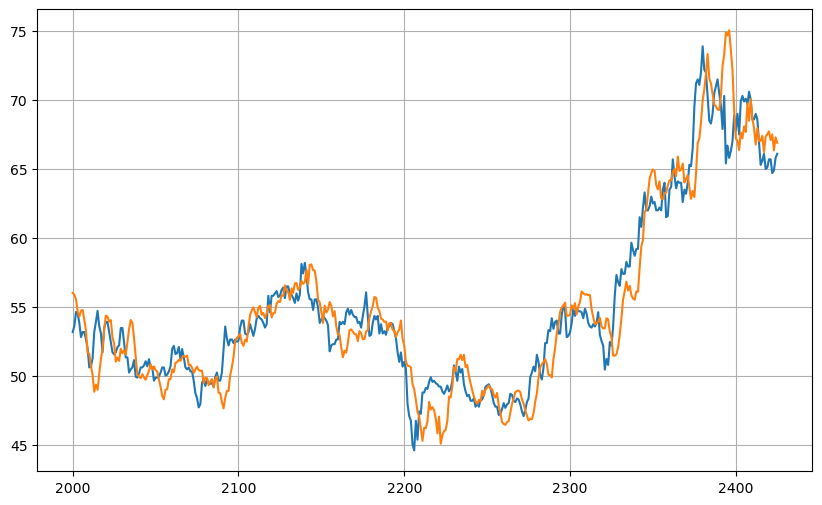

[56.00549  55.872684 55.54664  54.63463  54.28629  54.716984 54.77661
 54.062077 53.26379  51.672836 51.579075 50.717464 50.033806 48.840023
 49.35198  48.976017 50.10354  51.22076  51.9352   53.365097 54.358295
 54.290333 53.919144 54.031048 52.783134 52.33264  51.01707  51.304585
 51.074356 51.959854 51.632427 51.832165 51.53445  52.426746 53.382103
 54.040157 53.85633  52.72413  51.384953 50.065086 49.94121  49.82935
 50.113182 49.887844 49.708652 50.024513 50.35332  50.83424  50.453426
 50.675106 50.406677 50.29343  49.726734 49.204    48.537914 48.28903
 48.969337 49.019108 49.75108  49.742584 50.45775  50.248943 50.93714
 50.993637 51.15303  51.072617 51.34228  51.42439  51.370083 51.465973
 50.7684   50.78735  50.566452 50.20148  50.451527 50.652153 50.404152
 50.357594 50.372494 49.455486 49.845226 49.835403 49.311535 49.56279
 49.753834 49.14463  49.74705  49.955204 48.76206  48.73155  48.100464
 47.621365 48.378403 48.89834  48.891315 50.038525 50.59791  51.35152
 52.495747 5

In [58]:
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\REE.csv')
# Define the split time
split_time = 2000
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\REE.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

Epoch 1/100
62/62 [==============================] - 1s 4ms/step - loss: 16.3679 - mse: 339.1278
Epoch 2/100
62/62 [==============================] - 0s 4ms/step - loss: 15.5592 - mse: 307.5329
Epoch 3/100
62/62 [==============================] - 0s 4ms/step - loss: 14.7897 - mse: 278.9002
Epoch 4/100
62/62 [==============================] - 0s 4ms/step - loss: 14.1083 - mse: 254.8055
Epoch 5/100
62/62 [==============================] - 0s 4ms/step - loss: 13.4902 - mse: 234.0178
Epoch 6/100
62/62 [==============================] - 0s 4ms/step - loss: 12.9204 - mse: 215.6231
Epoch 7/100
62/62 [==============================] - 0s 4ms/step - loss: 12.3934 - mse: 199.0881
Epoch 8/100
62/62 [==============================] - 0s 4ms/step - loss: 11.8981 - mse: 184.2112
Epoch 9/100
62/62 [==============================] - 0s 4ms/step - loss: 11.4248 - mse: 170.4312
Epoch 10/100
62/62 [==============================] - 0s 4ms/step - loss: 10.9680 - mse: 157.7363
Epoch 11/100
62/62 [=========

62/62 [==============================] - 1s 5ms/step - loss: 0.3664 - mse: 1.8725
Epoch 87/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3645 - mse: 1.8592
Epoch 88/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3625 - mse: 1.8473
Epoch 89/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3606 - mse: 1.8349
Epoch 90/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3587 - mse: 1.8224
Epoch 91/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3568 - mse: 1.8101
Epoch 92/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3549 - mse: 1.7981
Epoch 93/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3529 - mse: 1.7851
Epoch 94/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3511 - mse: 1.7746
Epoch 95/100
62/62 [==============================] - 0s 4ms/step - loss: 0.3495 - mse: 1.7623
Epoch 96/100
62/62 [==============================] - 0s 4ms/st

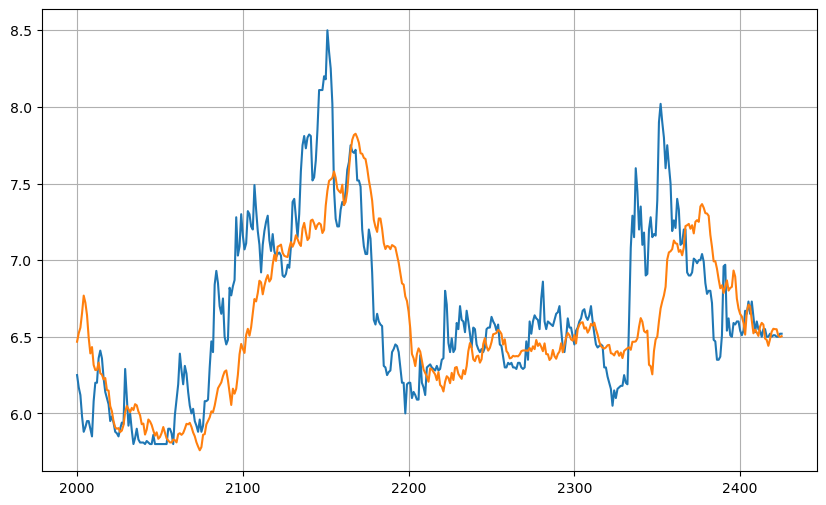

[6.467733  6.523537  6.55937   6.6547475 6.7686    6.7229934 6.6407394
 6.495129  6.391272  6.433133  6.316152  6.2827415 6.2845206 6.3314624
 6.262108  6.2525945 6.2225165 6.2307477 6.1527066 6.148624  6.0475354
 6.014855  5.947675  5.9087386 5.8997436 5.9040165 5.8785667 5.8877187
 5.923663  6.007273  6.0485816 6.027798  6.0079303 6.03597   6.0220847
 6.060083  6.052731  6.0124993 5.9878054 5.9294505 5.933743  5.8619223
 5.8940606 5.960295  5.947706  5.9245543 5.888205  5.854856  5.8765645
 5.834451  5.845937  5.8719735 5.9110956 5.874472  5.8370366 5.822986
 5.8106747 5.810332  5.829271  5.825353  5.8108363 5.8646398 5.8706307
 5.860181  5.8716817 5.8992915 5.9318566 5.92874   5.9382987 5.9120393
 5.875812  5.8508744 5.8115926 5.783767  5.7594075 5.7800374 5.860347
 5.864962  5.928474  5.9507885 5.9740577 6.013616  6.007747  6.0501285
 6.106423  6.164149  6.183306  6.202515  6.2427526 6.272493  6.2805076
 6.216819  6.1342473 6.055191  6.161458  6.128674  6.1610503 6.252163
 6.385867

In [63]:
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\SAM.csv')
# Define the split time
split_time = 2000
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\SAM.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

Epoch 1/100
62/62 [==============================] - 1s 3ms/step - loss: 41.4492 - mse: 2358.3616
Epoch 2/100
62/62 [==============================] - 0s 3ms/step - loss: 33.5101 - mse: 1532.3044
Epoch 3/100
62/62 [==============================] - 0s 4ms/step - loss: 23.6200 - mse: 763.2358
Epoch 4/100
62/62 [==============================] - 0s 3ms/step - loss: 13.5754 - mse: 260.5431
Epoch 5/100
62/62 [==============================] - 0s 3ms/step - loss: 3.4724 - mse: 25.5267
Epoch 6/100
62/62 [==============================] - 0s 4ms/step - loss: 0.8675 - mse: 4.9961
Epoch 7/100
62/62 [==============================] - 0s 3ms/step - loss: 0.8500 - mse: 4.8405
Epoch 8/100
62/62 [==============================] - 0s 3ms/step - loss: 0.8446 - mse: 4.8275
Epoch 9/100
62/62 [==============================] - 0s 3ms/step - loss: 0.8370 - mse: 4.7273
Epoch 10/100
62/62 [==============================] - 0s 3ms/step - loss: 0.8336 - mse: 4.7060
Epoch 11/100
62/62 [========================

62/62 [==============================] - 0s 3ms/step - loss: 0.5679 - mse: 2.5797
Epoch 88/100
62/62 [==============================] - 0s 3ms/step - loss: 0.5717 - mse: 2.6118
Epoch 89/100
62/62 [==============================] - 0s 3ms/step - loss: 0.5670 - mse: 2.5916
Epoch 90/100
62/62 [==============================] - 0s 3ms/step - loss: 0.5660 - mse: 2.5738
Epoch 91/100
62/62 [==============================] - 0s 3ms/step - loss: 0.5659 - mse: 2.5613
Epoch 92/100
62/62 [==============================] - 0s 3ms/step - loss: 0.5643 - mse: 2.5727
Epoch 93/100
62/62 [==============================] - 0s 3ms/step - loss: 0.5665 - mse: 2.5563
Epoch 94/100
62/62 [==============================] - 0s 3ms/step - loss: 0.5639 - mse: 2.5599
Epoch 95/100
62/62 [==============================] - 0s 3ms/step - loss: 0.5596 - mse: 2.5289
Epoch 96/100
62/62 [==============================] - 0s 3ms/step - loss: 0.5600 - mse: 2.5342
Epoch 97/100
62/62 [==============================] - 0s 3ms/st

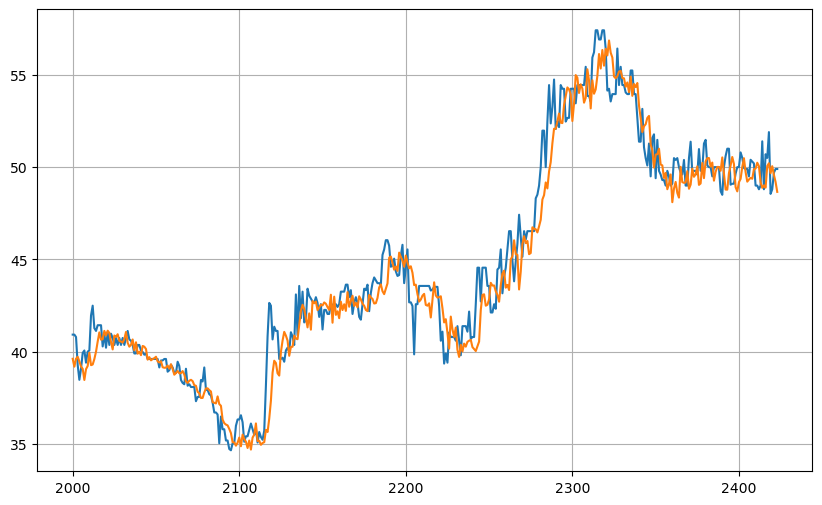

[39.610725 39.181965 39.615154 39.715664 39.470337 39.190945 39.066944
 38.462063 39.04892  39.22083  39.936954 39.263367 39.29797  39.59553
 39.996265 40.543865 41.041157 40.64728  40.668568 41.12202  40.877094
 41.133003 41.012623 40.519264 40.116425 40.87214  40.798904 40.940533
 40.580276 40.543938 40.48631  40.67713  41.066517 40.475807 40.26788
 40.365025 40.657627 40.066494 40.507202 39.8856   39.992596 39.80543
 40.307205 40.266014 40.141182 39.56425  39.699337 39.524784 39.596554
 39.641994 39.72134  39.466805 39.407494 39.48029  39.152267 39.123245
 39.12933  39.24628  39.074184 39.31546  39.05235  38.74743  38.836895
 38.950813 38.82269  38.83     38.9445   38.75825  38.385357 38.30322
 38.418015 38.47004  38.398872 38.180244 38.145798 37.816654 37.742046
 37.48585  37.48754  37.779808 38.00143  38.009556 37.910458 37.83594
 37.258392 37.223186 37.19003  37.57132  37.156147 37.061718 36.317043
 36.120197 36.041786 35.999813 35.805428 35.5819   35.0909   35.075127
 34.89899  

In [59]:
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\TMS.csv')
# Define the split time
split_time = 2000
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\TMS.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

Epoch 1/100
62/62 [==============================] - 1s 4ms/step - loss: 42.7084 - mse: 2194.3608
Epoch 2/100
62/62 [==============================] - 1s 5ms/step - loss: 11.7750 - mse: 221.8321
Epoch 3/100
62/62 [==============================] - 0s 4ms/step - loss: 1.6058 - mse: 8.2361
Epoch 4/100
62/62 [==============================] - 0s 4ms/step - loss: 1.3890 - mse: 6.6697
Epoch 5/100
62/62 [==============================] - 0s 4ms/step - loss: 1.2928 - mse: 6.0036
Epoch 6/100
62/62 [==============================] - 0s 4ms/step - loss: 1.1349 - mse: 5.1286
Epoch 7/100
62/62 [==============================] - 0s 4ms/step - loss: 1.0246 - mse: 4.3912
Epoch 8/100
62/62 [==============================] - 1s 8ms/step - loss: 0.9993 - mse: 4.2224
Epoch 9/100
62/62 [==============================] - 1s 5ms/step - loss: 0.9707 - mse: 3.9828
Epoch 10/100
62/62 [==============================] - 0s 5ms/step - loss: 0.9413 - mse: 3.8118
Epoch 11/100
62/62 [==============================] 

62/62 [==============================] - 0s 4ms/step - loss: 0.6103 - mse: 2.0100
Epoch 88/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6120 - mse: 2.0199
Epoch 89/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6108 - mse: 2.0099
Epoch 90/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6076 - mse: 1.9978
Epoch 91/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6090 - mse: 1.9960
Epoch 92/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6072 - mse: 1.9951
Epoch 93/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6054 - mse: 1.9791
Epoch 94/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6065 - mse: 1.9869
Epoch 95/100
62/62 [==============================] - 1s 6ms/step - loss: 0.6042 - mse: 1.9772
Epoch 96/100
62/62 [==============================] - 0s 4ms/step - loss: 0.6054 - mse: 1.9807
Epoch 97/100
62/62 [==============================] - 0s 4ms/st

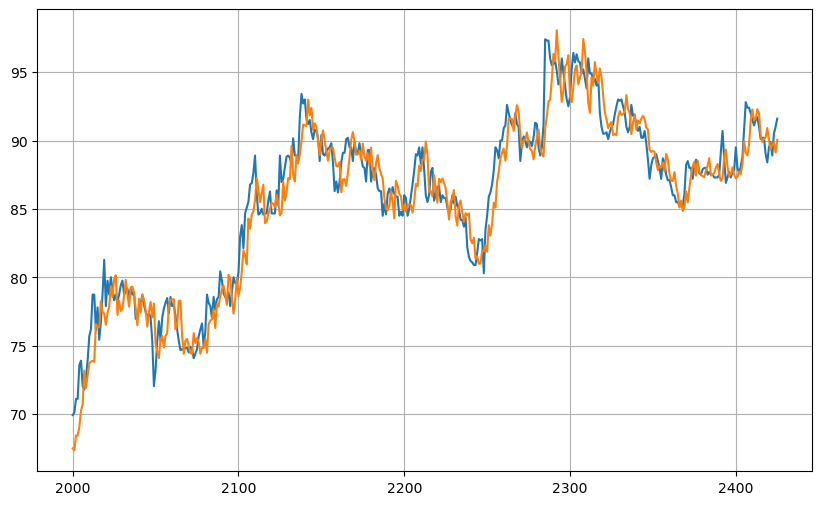

[67.500145 67.36648  68.45162  68.43554  69.0807   70.271095 70.68572
 73.187096 71.92288  72.798805 73.71999  73.84489  73.90033  73.82584
 76.585976 76.35454  76.35464  78.26022  77.48027  77.353836 76.53259
 77.39888  77.84389  79.3628   78.56245  79.84548  80.15509  77.253456
 78.30479  77.54072  77.70671  78.64872  79.81647  78.77619  77.86116
 79.26306  79.32472  78.886375 77.73215  76.49207  78.4338   77.41879
 78.734215 78.3706   77.626495 76.39993  77.50225  78.20613  77.081245
 78.09191  75.1572   74.5911   74.10191  75.47847  75.73521  74.87579
 75.73481  75.895515 77.96599  78.36791  78.37947  78.416145 76.21356
 76.47018  78.28083  78.30237  75.72433  74.41343  75.368484 75.506615
 74.991844 74.46284  74.41346  75.928566 75.18903  75.56906  75.26479
 74.42147  74.85238  74.832664 75.48675  74.502846 76.57495  76.85368
 76.93     77.66692  76.296005 78.046074 77.875824 78.5976   79.1296
 79.40826  78.70353  77.99819  80.18806  79.96546  78.54442  77.35145
 78.32796  79.9678

In [64]:
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\VCB.csv')
# Define the split time
split_time = 2000
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\VCB.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

Epoch 1/100
62/62 [==============================] - 1s 3ms/step - loss: 97.5406 - mse: 13890.2168
Epoch 2/100
62/62 [==============================] - 0s 3ms/step - loss: 4.5707 - mse: 53.4687
Epoch 3/100
62/62 [==============================] - 0s 3ms/step - loss: 3.0489 - mse: 28.9143
Epoch 4/100
62/62 [==============================] - 0s 3ms/step - loss: 2.9579 - mse: 26.6366
Epoch 5/100
62/62 [==============================] - 0s 3ms/step - loss: 2.6690 - mse: 22.3831
Epoch 6/100
62/62 [==============================] - 0s 3ms/step - loss: 2.3246 - mse: 17.5787
Epoch 7/100
62/62 [==============================] - 0s 3ms/step - loss: 2.1323 - mse: 14.9513
Epoch 8/100
62/62 [==============================] - 0s 3ms/step - loss: 2.0408 - mse: 13.8558
Epoch 9/100
62/62 [==============================] - 0s 3ms/step - loss: 1.9983 - mse: 13.2522
Epoch 10/100
62/62 [==============================] - 0s 3ms/step - loss: 1.9650 - mse: 12.9298
Epoch 11/100
62/62 [=========================

62/62 [==============================] - 0s 3ms/step - loss: 1.2494 - mse: 6.2031
Epoch 88/100
62/62 [==============================] - 0s 3ms/step - loss: 1.2314 - mse: 6.1236
Epoch 89/100
62/62 [==============================] - 0s 3ms/step - loss: 1.2344 - mse: 6.0669
Epoch 90/100
62/62 [==============================] - 0s 3ms/step - loss: 1.2169 - mse: 5.9950
Epoch 91/100
62/62 [==============================] - 0s 3ms/step - loss: 1.2392 - mse: 6.1048
Epoch 92/100
62/62 [==============================] - 0s 3ms/step - loss: 1.2153 - mse: 5.9599
Epoch 93/100
62/62 [==============================] - 0s 3ms/step - loss: 1.2111 - mse: 5.9463
Epoch 94/100
62/62 [==============================] - 0s 3ms/step - loss: 1.2280 - mse: 6.0524
Epoch 95/100
62/62 [==============================] - 0s 3ms/step - loss: 1.2391 - mse: 6.1300
Epoch 96/100
62/62 [==============================] - 0s 3ms/step - loss: 1.2234 - mse: 6.0275
Epoch 97/100
62/62 [==============================] - 0s 3ms/st

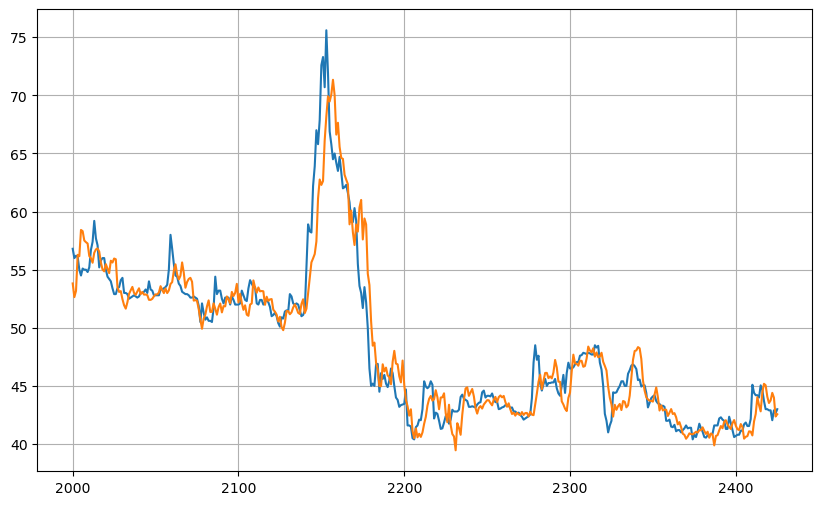

[53.818478 52.64038  53.180054 56.28145  56.161423 58.420197 58.317337
 57.509884 57.36765  57.25375  56.176067 55.986973 55.59852  56.456333
 56.744354 56.829086 56.561104 55.617928 55.020775 54.857483 55.475693
 55.087807 54.70501  55.77305  55.617477 55.962215 55.89727  53.49303
 53.083595 53.159378 52.47151  51.943947 51.649483 52.19738  52.919785
 53.23262  53.519802 53.00112  52.839104 53.133537 53.40087  52.897873
 53.08545  52.859367 52.865387 52.818726 52.408806 52.40296  52.493202
 52.71125  52.880226 52.872425 53.04139  53.580612 53.25505  52.990368
 53.388348 52.989044 53.216064 53.767223 53.93093  54.89646  55.464134
 54.59944  54.15809  54.48286  55.624268 54.742435 53.448044 53.94137
 54.20324  54.300842 53.961777 52.337936 52.385433 52.323624 51.62358
 50.733326 49.920677 50.796913 51.12561  51.84339  52.36046  51.36035
 51.377415 52.104412 51.643265 51.13002  51.782207 52.09169  51.32594
 51.869102 51.847004 52.700348 52.4336   52.11209  53.08795  52.734604
 53.006516 

In [60]:
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\VIC.csv')
# Define the split time
split_time = 2000
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\VIC.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

Epoch 1/100
46/46 [==============================] - 1s 5ms/step - loss: 125.6566 - mse: 29188.2578
Epoch 2/100
46/46 [==============================] - 0s 5ms/step - loss: 52.6891 - mse: 4732.3594
Epoch 3/100
46/46 [==============================] - 0s 5ms/step - loss: 45.0197 - mse: 3522.6177
Epoch 4/100
46/46 [==============================] - 0s 5ms/step - loss: 35.9557 - mse: 2372.3455
Epoch 5/100
46/46 [==============================] - 0s 7ms/step - loss: 32.2740 - mse: 1943.4546
Epoch 6/100
46/46 [==============================] - 0s 5ms/step - loss: 29.1643 - mse: 1593.1329
Epoch 7/100
46/46 [==============================] - 0s 5ms/step - loss: 28.1771 - mse: 1470.7401
Epoch 8/100
46/46 [==============================] - 0s 5ms/step - loss: 24.4777 - mse: 1146.1747
Epoch 9/100
46/46 [==============================] - 0s 6ms/step - loss: 22.0265 - mse: 933.5595
Epoch 10/100
46/46 [==============================] - 0s 5ms/step - loss: 27.1755 - mse: 1311.0316
Epoch 11/100
46/46

46/46 [==============================] - 0s 4ms/step - loss: 14.8470 - mse: 453.6956
Epoch 85/100
46/46 [==============================] - 0s 4ms/step - loss: 15.8002 - mse: 503.5829
Epoch 86/100
46/46 [==============================] - 0s 4ms/step - loss: 17.2154 - mse: 559.7080
Epoch 87/100
46/46 [==============================] - 0s 4ms/step - loss: 18.9934 - mse: 680.9537
Epoch 88/100
46/46 [==============================] - 0s 4ms/step - loss: 16.8221 - mse: 532.5475
Epoch 89/100
46/46 [==============================] - 0s 4ms/step - loss: 14.8905 - mse: 457.6189
Epoch 90/100
46/46 [==============================] - 0s 4ms/step - loss: 14.9343 - mse: 462.2382
Epoch 91/100
46/46 [==============================] - 0s 4ms/step - loss: 16.9204 - mse: 530.9763
Epoch 92/100
46/46 [==============================] - 0s 4ms/step - loss: 14.6196 - mse: 444.7309
Epoch 93/100
46/46 [==============================] - 0s 4ms/step - loss: 16.4841 - mse: 530.4868
Epoch 94/100
46/46 [=============

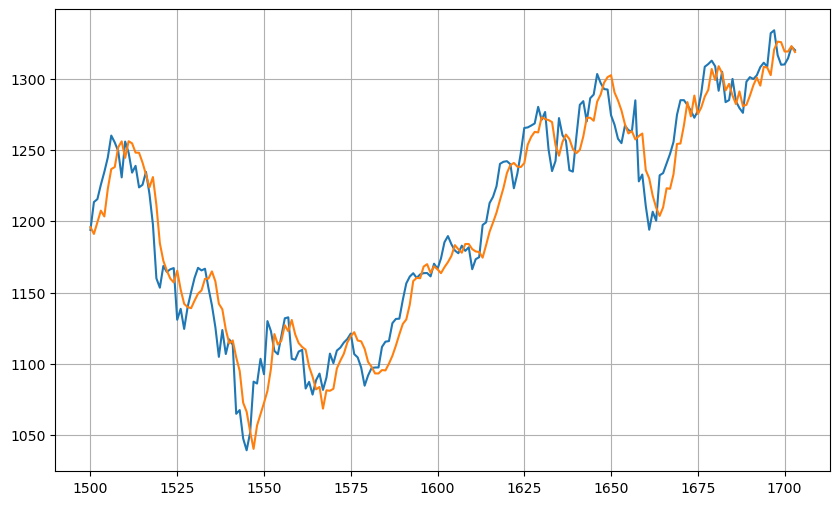

[1195.8463 1191.0629 1199.1605 1207.4001 1203.3418 1222.658  1236.5504
 1237.926  1251.8193 1255.9656 1244.3967 1256.0615 1254.5725 1248.0658
 1247.9956 1241.1348 1232.731  1223.6885 1230.941  1211.3235 1184.501
 1172.2509 1165.3811 1159.776  1157.0509 1165.2592 1152.0344 1142.0564
 1139.7762 1138.9888 1144.3109 1149.186  1151.4738 1159.5615 1159.7462
 1164.7937 1157.7354 1142.0903 1138.2157 1123.9689 1114.3159 1116.3998
 1104.512  1095.0233 1072.7283 1066.4368 1052.7307 1040.3557 1056.7518
 1064.7292 1072.5985 1081.0312 1096.4663 1120.8507 1113.517  1116.2125
 1127.0642 1122.8378 1130.7545 1120.5808 1114.5016 1111.7975 1109.9021
 1098.0667 1090.9457 1082.0997 1083.7687 1068.5706 1081.4155 1081.0826
 1082.5044 1096.7272 1102.1841 1107.0111 1114.8503 1119.4021 1122.1725
 1116.3444 1115.7715 1110.4877 1101.2952 1097.8911 1093.2662 1093.2272
 1095.6173 1095.3756 1100.0929 1105.616  1112.7313 1120.6534 1127.954
 1131.1123 1141.4609 1158.0123 1160.2504 1160.0137 1168.1772 1169.8556
 1163.80

In [66]:
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\VN30.csv')
# Define the split time
split_time = 1500
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\VN30.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 500

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

Epoch 1/100
62/62 [==============================] - 1s 3ms/step - loss: 271.6874 - mse: 147182.2344
Epoch 2/100
62/62 [==============================] - 0s 3ms/step - loss: 36.4574 - mse: 2557.8225
Epoch 3/100
62/62 [==============================] - 0s 3ms/step - loss: 32.8301 - mse: 2278.0269
Epoch 4/100
62/62 [==============================] - 0s 3ms/step - loss: 30.8550 - mse: 2051.6951
Epoch 5/100
62/62 [==============================] - 0s 3ms/step - loss: 29.8517 - mse: 1923.4459
Epoch 6/100
62/62 [==============================] - 0s 3ms/step - loss: 29.0899 - mse: 1821.1150
Epoch 7/100
62/62 [==============================] - 0s 3ms/step - loss: 28.9577 - mse: 1782.0778
Epoch 8/100
62/62 [==============================] - 0s 3ms/step - loss: 27.8745 - mse: 1588.1873
Epoch 9/100
62/62 [==============================] - 0s 3ms/step - loss: 26.4518 - mse: 1521.5182
Epoch 10/100
62/62 [==============================] - 0s 3ms/step - loss: 26.7763 - mse: 1511.5360
Epoch 11/100
62/

62/62 [==============================] - 0s 3ms/step - loss: 13.1820 - mse: 388.8221
Epoch 85/100
62/62 [==============================] - 0s 3ms/step - loss: 14.1760 - mse: 415.2088
Epoch 86/100
62/62 [==============================] - 0s 3ms/step - loss: 13.5525 - mse: 389.0556
Epoch 87/100
62/62 [==============================] - 0s 3ms/step - loss: 14.2172 - mse: 423.9182
Epoch 88/100
62/62 [==============================] - 0s 3ms/step - loss: 12.2735 - mse: 343.0726
Epoch 89/100
62/62 [==============================] - 0s 3ms/step - loss: 12.4780 - mse: 353.8395
Epoch 90/100
62/62 [==============================] - 0s 3ms/step - loss: 12.8387 - mse: 365.4356
Epoch 91/100
62/62 [==============================] - 0s 3ms/step - loss: 13.0943 - mse: 367.9147
Epoch 92/100
62/62 [==============================] - 0s 3ms/step - loss: 12.7272 - mse: 363.5158
Epoch 93/100
62/62 [==============================] - 0s 3ms/step - loss: 13.1337 - mse: 373.7976
Epoch 94/100
62/62 [=============

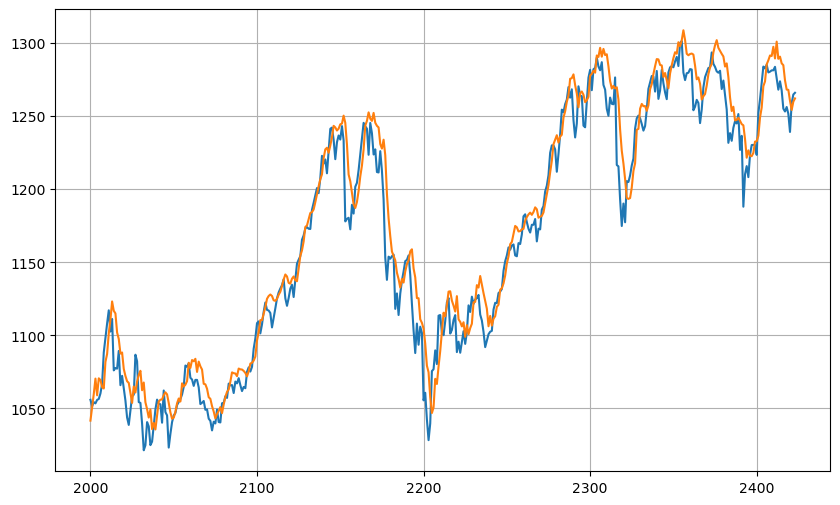

[1041.5582 1050.473  1059.8344 1070.3411 1058.9033 1070.5214 1069.3702
 1064.4701 1063.5765 1081.8225 1087.1705 1101.3666 1110.7382 1123.1733
 1116.7948 1114.9675 1101.9175 1097.4584 1087.4701 1088.2086 1076.9926
 1072.1697 1068.5486 1067.3794 1060.3055 1053.7001 1064.9619 1060.7585
 1068.3136 1072.8495 1075.6814 1062.3826 1067.6501 1054.1011 1049.4402
 1043.6472 1049.1569 1035.7551 1040.0209 1035.479  1045.2461 1054.6505
 1055.8593 1056.072  1058.9523 1060.9397 1059.5338 1053.6664 1047.1917
 1042.8641 1043.5702 1047.4722 1053.4208 1056.6998 1054.6431 1067.112
 1064.9347 1066.127  1068.6349 1081.2023 1077.6185 1083.0436 1082.1959
 1083.9021 1074.9193 1081.9802 1078.7418 1076.5288 1066.7842 1066.4282
 1063.3785 1057.6007 1056.4777 1051.4574 1047.7944 1043.0897 1046.1047
 1048.2395 1050.8535 1046.7019 1052.6061 1057.7751 1061.2274 1062.8859
 1068.2296 1074.6075 1074.0288 1073.8501 1071.9933 1077.2286 1076.6605
 1076.5476 1075.6018 1074.2067 1071.8845 1075.3275 1080.6259 1081.2062
 1082.6

In [61]:
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\VNINDEX.csv')
# Define the split time
split_time = 2000
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\VNINDEX.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)

Epoch 1/100
62/62 [==============================] - 1s 4ms/step - loss: 79.3865 - mse: 6852.2251
Epoch 2/100
62/62 [==============================] - 0s 4ms/step - loss: 51.6196 - mse: 2908.4807
Epoch 3/100
62/62 [==============================] - 0s 3ms/step - loss: 24.7701 - mse: 769.1284
Epoch 4/100
62/62 [==============================] - 0s 4ms/step - loss: 2.8153 - mse: 19.1736
Epoch 5/100
62/62 [==============================] - 0s 4ms/step - loss: 2.1856 - mse: 13.0600
Epoch 6/100
62/62 [==============================] - 0s 4ms/step - loss: 2.0343 - mse: 11.6643
Epoch 7/100
62/62 [==============================] - 0s 4ms/step - loss: 2.0002 - mse: 11.2685
Epoch 8/100
62/62 [==============================] - 0s 4ms/step - loss: 1.9747 - mse: 11.0555
Epoch 9/100
62/62 [==============================] - 0s 4ms/step - loss: 1.9590 - mse: 10.8528
Epoch 10/100
62/62 [==============================] - 1s 6ms/step - loss: 1.9310 - mse: 10.6005
Epoch 11/100
62/62 [=====================

62/62 [==============================] - 0s 4ms/step - loss: 1.1360 - mse: 4.6016
Epoch 88/100
62/62 [==============================] - 0s 4ms/step - loss: 1.1406 - mse: 4.6112
Epoch 89/100
62/62 [==============================] - 0s 4ms/step - loss: 1.1299 - mse: 4.5478
Epoch 90/100
62/62 [==============================] - 0s 4ms/step - loss: 1.1198 - mse: 4.5087
Epoch 91/100
62/62 [==============================] - 0s 4ms/step - loss: 1.1246 - mse: 4.5481
Epoch 92/100
62/62 [==============================] - 0s 4ms/step - loss: 1.1206 - mse: 4.4890
Epoch 93/100
62/62 [==============================] - 0s 4ms/step - loss: 1.1060 - mse: 4.4397
Epoch 94/100
62/62 [==============================] - 0s 4ms/step - loss: 1.1046 - mse: 4.4341
Epoch 95/100
62/62 [==============================] - 0s 4ms/step - loss: 1.0979 - mse: 4.3878
Epoch 96/100
62/62 [==============================] - 0s 5ms/step - loss: 1.1011 - mse: 4.4003
Epoch 97/100
62/62 [==============================] - 0s 4ms/st

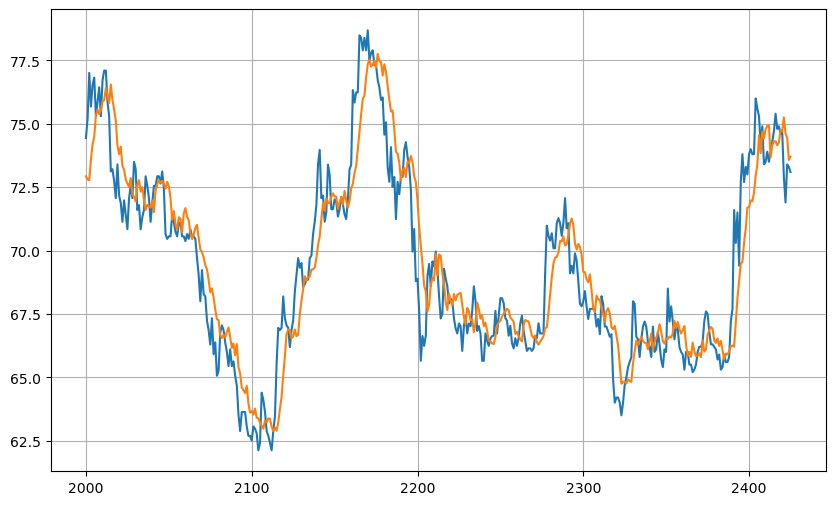

[72.93012  72.802536 72.774994 73.578285 74.19728  74.48861  75.33977
 75.55986  75.38602  75.54044  75.882    75.92828  76.418625 76.16084
 75.81478  76.552536 75.94267  75.55834  75.119156 74.145836 73.80494
 74.1009   73.34411  73.19833  72.79672  72.64845  72.50091  72.85804
 72.22809  72.11194  71.938416 72.59973  72.77887  72.32518  72.50803
 71.98446  71.60152  71.804855 71.74991  71.69347  71.97183  71.5126
 72.3654   72.615105 72.77799  72.677925 72.749596 72.62914  72.440575
 72.711174 72.540565 72.077705 71.20452  71.55726  71.03864  70.81847
 71.313225 71.26728  70.7265   71.45699  71.67201  71.336655 71.192726
 70.679375 70.451515 70.63905  70.89824  71.011665 70.4989   70.04576
 69.93867  69.73297  69.4208   69.26038  68.847084 68.34971  68.51141
 68.14519  67.66949  67.291916 67.25359  66.646324 66.54937  66.68189
 66.57336  66.79499  66.96749  66.58286  66.16207  66.33075  65.8671
 66.31491  65.41113  65.14291  64.5879   64.489296 64.37776  64.66723
 63.97098  63.603825

In [53]:
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\VNM.csv')
# Define the split time
split_time = 2000
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\VNM.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)